In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
file_path = "C:/Users/ATAISH NEHRA/Downloads/merged_natural_disaster_dataset_1992_2020.csv"  
data = pd.read_csv(file_path)

In [5]:

# Assuming 'Country', 'Year', and other feature columns are in the dataset
feature_columns = ['Temperature', 'Drought', 'Extreme temperature', 'Flood', 'Landslide', 'Storm', 'Wildfire', 'Forest area', 'Carbon stocks in forests']
target_column = 'Total Disasters'

# Scale the features
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(data[feature_columns])

# Scale the target
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_scaled = scaler_y.fit_transform(data[[target_column]])

In [14]:
# Function to create sequences by country
def create_sequences_by_country(X, y, n_steps, data):
    Xs, ys = [], []
    countries = data['Country'].unique()
    for country in countries:
        country_indices = data[data['Country'] == country].index
        country_data_X = X[country_indices]
        country_data_y = y[country_indices]
        for i in range(len(country_data_X) - n_steps):
            Xs.append(country_data_X[i:(i + n_steps)])
            ys.append(country_data_y[i + n_steps])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

n_steps = 3  # Using 3 years of data to predict the next year
X_seq, y_seq = create_sequences_by_country(X_scaled, y_scaled, n_steps, data)

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42)

In [15]:
# Define LSTM model
model = Sequential([
    LSTM(100, activation='relu', input_shape=(n_steps, len(feature_columns))),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [16]:
# Train the model
history = model.fit(X_train, y_train, epochs=500, validation_split=0.3, verbose=2)

Epoch 1/500
13/13 - 1s - loss: 0.0472 - val_loss: 0.0328 - 1s/epoch - 106ms/step
Epoch 2/500
13/13 - 0s - loss: 0.0372 - val_loss: 0.0311 - 62ms/epoch - 5ms/step
Epoch 3/500
13/13 - 0s - loss: 0.0355 - val_loss: 0.0302 - 57ms/epoch - 4ms/step
Epoch 4/500
13/13 - 0s - loss: 0.0349 - val_loss: 0.0297 - 58ms/epoch - 4ms/step
Epoch 5/500
13/13 - 0s - loss: 0.0341 - val_loss: 0.0294 - 60ms/epoch - 5ms/step
Epoch 6/500
13/13 - 0s - loss: 0.0334 - val_loss: 0.0288 - 56ms/epoch - 4ms/step
Epoch 7/500
13/13 - 0s - loss: 0.0327 - val_loss: 0.0281 - 70ms/epoch - 5ms/step
Epoch 8/500
13/13 - 0s - loss: 0.0317 - val_loss: 0.0278 - 61ms/epoch - 5ms/step
Epoch 9/500
13/13 - 0s - loss: 0.0307 - val_loss: 0.0267 - 58ms/epoch - 4ms/step
Epoch 10/500
13/13 - 0s - loss: 0.0293 - val_loss: 0.0253 - 55ms/epoch - 4ms/step
Epoch 11/500
13/13 - 0s - loss: 0.0279 - val_loss: 0.0246 - 61ms/epoch - 5ms/step
Epoch 12/500
13/13 - 0s - loss: 0.0258 - val_loss: 0.0229 - 66ms/epoch - 5ms/step
Epoch 13/500
13/13 - 0s -

In [17]:
# Predictions
predictions_scaled = model.predict(X_test)

In [18]:
# Inverse transform predictions
predictions = scaler_y.inverse_transform(predictions_scaled)

# Compare predictions with actual values (optional)
y_test_actual = scaler_y.inverse_transform(y_test)
comparison = pd.DataFrame({'Actual': y_test_actual.flatten(), 'Predicted': predictions.flatten()})
print(comparison.head())

   Actual  Predicted
0     4.0   3.327861
1     6.0   8.344270
2     7.0   2.018816
3     3.0   3.698024
4     3.0   3.034119


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_actual, predictions)

print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 12.362483534992851
Root Mean Squared Error: 3.516032356932008
Mean Absolute Error: 2.4417360240270285


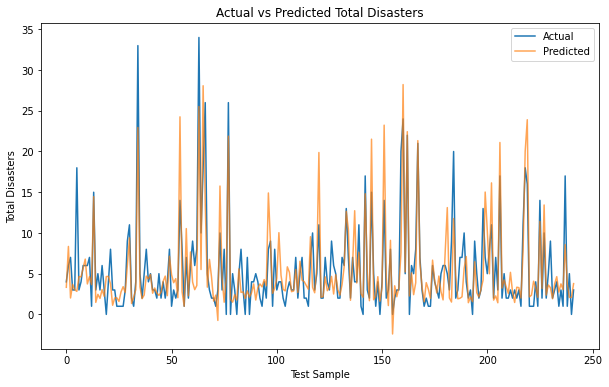

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Total Disasters')
plt.xlabel('Test Sample')
plt.ylabel('Total Disasters')
plt.legend()
plt.show()

In [33]:
def predict_disaster_for_country_year(data, model, scaler_X, scaler_y, feature_columns, country, input_year):
    # Convert input_year from string to int
    input_year = int(input_year)
    
    # Filter data for the selected country and up to the selected year
    country_data = data[(data['Country'] == country) & (data['Year'] >= input_year - 2) & (data['Year'] <= input_year)]
    
    if len(country_data) < 3:
        print(f"Not enough data for {country} leading up to {input_year}.")
        return
    
    # Convert to DataFrame to maintain feature names
    features_df = country_data[feature_columns]
    features_scaled = scaler_X.transform(features_df)  # Scale features
    features_reshaped = features_scaled.reshape(1, 3, len(feature_columns))  # Reshape for the model
    
    # Make prediction
    predicted_scaled = model.predict(features_reshaped)
    predicted = scaler_y.inverse_transform(predicted_scaled)[0][0]  # Inverse transform prediction
    
    # Get actual value for the year
    actual_value = data[(data['Country'] == country) & (data['Year'] == input_year)][target_column].values[0] if len(data[(data['Country'] == country) & (data['Year'] == input_year)][target_column]) > 0 else None
    
    if actual_value is not None:
        # Calculate accuracy percentage
        accuracy = max(0, 1 - abs(predicted - actual_value) / actual_value) * 100
        
        print(f"Country: {country}, Year: {input_year}")
        print(f"Actual 'Total Disasters': {actual_value}")
        print(f"Predicted 'Total Disasters': {predicted:.2f}")
        print(f"Accuracy: {accuracy:.2f}%")
    else:
        print(f"No actual data available for {country} in {input_year}.")
        print(f"Predicted 'Total Disasters': {predicted:.2f}")

In [34]:
# Example usage
user_country = input("Enter country name: ")
user_year = input("Enter a year between 2017 and 2020: ")

predict_disaster_for_country_year(data, model, scaler_X, scaler_y, feature_columns, user_country, user_year)

Enter country name:  Argentina
Enter a year between 2017 and 2020:  2019


Country: Argentina, Year: 2019
Actual 'Total Disasters': 4
Predicted 'Total Disasters': 3.70
Accuracy: 92.43%


In [35]:
# Example usage
user_country = input("Enter country name: ")
user_year = input("Enter a year between 2017 and 2020: ")

predict_disaster_for_country_year(data, model, scaler_X, scaler_y, feature_columns, user_country, user_year)

Enter country name:  Thailand
Enter a year between 2017 and 2020:  2019


Country: Thailand, Year: 2019
Actual 'Total Disasters': 3
Predicted 'Total Disasters': 2.69
Accuracy: 89.64%


In [38]:
# Example usage
user_country = input("Enter country name: ")
user_year = input("Enter a year between 2017 and 2020: ")

predict_disaster_for_country_year(data, model, scaler_X, scaler_y, feature_columns, user_country, user_year)

Enter country name:  Nepal
Enter a year between 2017 and 2020:  2017


Country: Nepal, Year: 2017
Actual 'Total Disasters': 3
Predicted 'Total Disasters': 2.60
Accuracy: 86.58%
